# Whistle Detection with Continuous Kernel Convolutional Networks

In [9]:
from config import *
import os

config_path = os.path.join("config","config.yaml")
config: Config = load_config(config_path)
torch_config: TorchConfig = config.torch
dataset_config: DatasetConfig = config.dataset
trainer_config: TrainerConfig = config.trainer
baseline_config: BaselineConfig = config.baseline
whistlenet_config: WhistlenetConfig = config.whistlenet

In [10]:
import torch
import numpy as np
torch.manual_seed(torch_config.seed)
np.random.seed(torch_config.seed)

## Dataset Preparation

In [11]:
from whistlenet.data import WhistleDataset

dataset = WhistleDataset(dataset_config)
dataset.summarize()

DATA LOADED!

N Examples: 490053
N Classes: 2
Classes: [0. 1.]
 - Class 0: 273375 (55.784782462305095)
 - Class 1: 216678 (44.2152175376949)


## Model 

In [12]:
from whistlenet.models import WhistleNet, Baseline

# model = WhistleNet(in_channels=1, out_channels=1, config=whistlenet_config)
model = Baseline(config=baseline_config)

## Trainer

In [13]:
from whistlenet.core import Trainer
trainer = Trainer(trainer_config)
# trainer.fit(model,dataset)
model.load()

MODEL LOADED!


## Plotting

MODEL LOADED!


/home/neverorfrog/code/whistle/whistlenet/whistlenet/models/baseline.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
/home/neverorfrog/code/whistle/whistlenet/whistlenet/models/baseline.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
/home/neverorfrog/code/whistle/whistlenet/whistlenet/models/baseline.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
/home/neverorfrog/code/whistle/whistlenet/whistlenet

,precision,recall,f1-score,support
0.0,0.997798,0.981126,0.989386,977.208333
1.0,0.707353,0.954189,0.811088,46.680556
macro avg,0.852575,0.967657,0.900237,1023.888889
weighted avg,0.984739,0.979917,0.981386,1023.888889


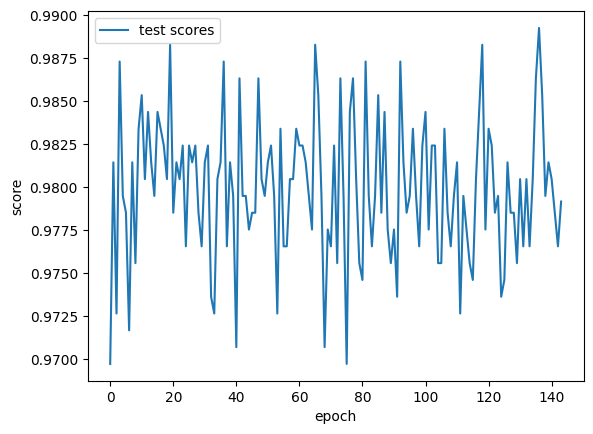

In [14]:
import matplotlib.pyplot as plt

complete_plot = False
    
model.load()
model.evaluate(dataset)
plt.plot(model.test_scores, label='test scores')
plt.legend()
plt.ylabel('score')
plt.xlabel('epoch')
plt.show()

## Inference on test audio

frame 0, time 0.00
Prediction: 0, elapsed: 0.0013
frame 1, time 0.02
Prediction: 0, elapsed: 0.0004
frame 2, time 0.05
Prediction: 0, elapsed: 0.0005
frame 3, time 0.07
Prediction: 0, elapsed: 0.0004
frame 4, time 0.09
Prediction: 0, elapsed: 0.0004
frame 5, time 0.12
Prediction: 0, elapsed: 0.0004
frame 6, time 0.14
Prediction: 0, elapsed: 0.0004
frame 7, time 0.16
Prediction: 0, elapsed: 0.0003
frame 8, time 0.19
Prediction: 0, elapsed: 0.0003
frame 9, time 0.21
Prediction: 0, elapsed: 0.0003
frame 10, time 0.23
Prediction: 0, elapsed: 0.0003
frame 11, time 0.26
Prediction: 0, elapsed: 0.0003
frame 12, time 0.28
Prediction: 0, elapsed: 0.0003
frame 13, time 0.30
Prediction: 0, elapsed: 0.0003
frame 14, time 0.33
Prediction: 0, elapsed: 0.0003
frame 15, time 0.35
Prediction: 0, elapsed: 0.0003
frame 16, time 0.37
Prediction: 0, elapsed: 0.0003
frame 17, time 0.39
Prediction: 0, elapsed: 0.0003
frame 18, time 0.42
Prediction: 0, elapsed: 0.0003
frame 19, time 0.44
Prediction: 0, elapse

/home/neverorfrog/code/whistle/whistlenet/whistlenet/models/baseline.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


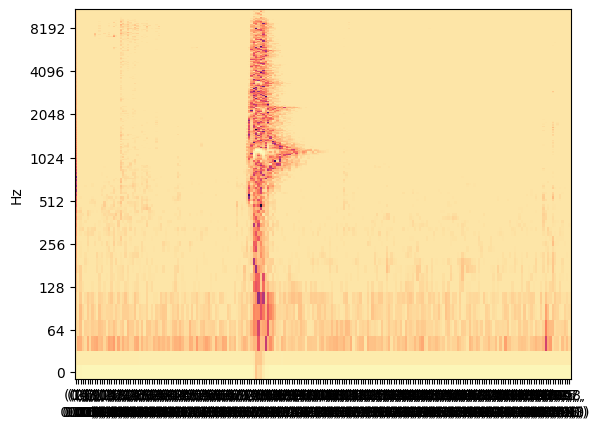

In [15]:
import torch
from whistlenet.core.utils import Audio, project_root
import time

def classify(window):
    with torch.no_grad():
        start = time.time()
        prediction = 1 if model(window) > 0.5 else 0
        elapsed = time.time() - start
        print(f"Prediction: {prediction}, elapsed: {elapsed:.4f}")
        return prediction


projroot = project_root()
audio = Audio(name="test2", datapath=f'{projroot}/data/whistle/raw/test')
for i in range(audio.S.shape[1]):
    window = torch.from_numpy(audio.S[:,i].reshape(1,1,513))
    print(f"frame {i}, time {audio.frame2time(i):.2f}")
    classify(window)
audio.freq_plot()

## Export to ONNX

In [16]:
file = f"{projroot}/models/{model.name}/whistle.onnx"

torch.onnx.export(
    model,
    model.example_input[0],
    f = file,
    input_names=["input"],
    output_names=["output"],
)

/home/neverorfrog/code/whistle/whistlenet/whistlenet/models/baseline.py:108: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  x = torch.tensor(x, dtype=torch.float32)
/home/neverorfrog/code/whistle/whistlenet/whistlenet/models/baseline.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
/home/neverorfrog/.miniconda3/envs/ccnn/lib/python3.11/site-packages/torch/onnx/_internal/jit_utils.py:307: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally a